In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from catboost import CatBoostRegressor

from numpy.lib.stride_tricks import sliding_window_view

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

In [2]:
class BoxNormal:
  def __init__(self):
    self.log_norm = lambda x: np.log(x + 1)
    self.exp_norm = lambda x: np.exp(x) - 1

  def to_logs(self, x):
    return self.log_norm(x)

  def to_exps(self, x):
    return self.exp_norm(x)

In [82]:
#### Параметры для выбора размера окна и кол-ва предсказаний ####
shift_forward = 29
shift_backward = 58

log_scaler = BoxNormal()

In [83]:
def data_load():
    #### Загружаем данные ####
    #df = pd.read_excel('data/Данные.xlsx', index_col=0)
    df = pd.read_excel('data/Данные.xlsx')
    izm_cats = pd.read_csv('data/ver-izmenenie-trat-po-kategoriyam.csv', encoding='cp1251', sep=';')

    #### Добавляем сторонние данные к датасету ####
    izm_cats['week'] = pd.to_datetime(izm_cats['date']).dt.isocalendar().week
    izm_cats['year'] = pd.to_datetime(izm_cats['date']).dt.isocalendar().year

    needs_cats = izm_cats[izm_cats['category'] == 'Лекарства и медицинские товары'].drop(columns=['date'])

    df = df.merge(needs_cats, on = ['week', 'year'], how = 'left').drop(columns=['category'])
    df.drop_duplicates(inplace=True)

    #### Обрезаем ковид (частично) ####
    df = (df[df['start_date'] >= '2020-07-20']).reset_index(drop=True)
    
    return df ### По этому df выбор столбцов
    
#### !!!!!!!!!! Можем убирать следующие столбцы: 'tv', 'digital', 'radio', 'count' и любых competitors !!!!!!!!!! ####

In [84]:
def data_proccesing(df):
    #### Находим столбцы конкурентов которые есть ####
    competitors_cols = []
    for i in df.columns:
        if 'competitor' in i:
            competitors_cols.append(i)

    #### Складываем оставшиеся столбцы конкурентов ####
    df['competitors'] = 0
    for i in competitors_cols:
        df['competitors'] += df[i]

    #### Удаляем оставшиеся столбцы конкурентов ####
    df = df.drop(columns = competitors_cols)
    
    #### Считаем окна данных ####
    wind_df = df[['sickness', 'generics', 'wordstat', 'value', 'competitors']]
    window = sliding_window_view(wind_df, shift_backward, 0)

    mean_sickness = []
    mean_generics = []
    mean_wordstat = []
    mean_value = []
    mean_competitors = []

    std_sickness = []
    std_generics = []
    std_wordstat = []
    std_value = []
    std_competitors = []

    for i in window:
        mean_sickness.append(np.mean(i[0]))
        mean_generics.append(np.mean(i[1]))
        mean_wordstat.append(np.mean(i[2]))
        mean_value.append(np.mean(i[3]))
        mean_competitors.append(np.mean(i[4]))

        std_sickness.append(np.std(i[0]))
        std_generics.append(np.std(i[1]))
        std_wordstat.append(np.std(i[2]))
        std_value.append(np.std(i[3]))
        std_competitors.append(np.std(i[4]))

    #### Делаем лаги для пронозируемых значений ####
    if 'count' in df:
        for i in range(1, shift_backward):
            df[f'sales_shift_{i}'] = df['sales'].shift(i)
            df[f'count_shift_{i}'] = df['count'].shift(i)
    else:
        for i in range(1, shift_backward):
            df[f'sales_shift_{i}'] = df['sales'].shift(i)

    df = df.dropna().reset_index(drop=True)

    #### Заполняем ДФ посчитанными значениями из окон ####
    df['mean_sickness'] = mean_sickness
    df['mean_generics'] = mean_generics
    df['mean_wordstat'] = mean_wordstat
    df['mean_value'] = mean_value
    df['mean_competitors'] = mean_competitors

    df['std_sickness'] = std_sickness
    df['std_generics'] = std_generics
    df['std_wordstat'] = std_wordstat
    df['std_value'] = std_value
    df['std_competitors'] = std_competitors

    #### Убираем лишние колонки ####
    df = df.drop(columns=['start_date', 'sickness', 'generics', 'wordstat', 'value', 'competitors'])
    
    return df ### По этому df можно сделать еще один выбор столбцов
    
#### !!!!!!!!!! Можем убирать следующие столбцы: 'mean_sickness', 'std_sickness',... и так далее! !!!!!!!!!! ####

In [85]:
def data_postproccesing(df):

    #### Загружаем хвост известных наперед данных ####
    xvost = pd.read_excel('data/Хвост_0.xlsx', index_col = 0)

    #### Дополняем известные данные для sample_submission ####
    if 'tv' in df:
        for i in range(1, shift_forward+1):
            df[f'tv_{i}'] = df['tv'].shift(-i)
            df.loc[len(df)-1:, f'tv_{i}'] = xvost.iloc[i-1,0]
    if 'digital' in df:
        for i in range(1, shift_forward+1):
            df[f'digital_{i}'] = df['digital'].shift(-i)
            df.loc[len(df)-1:, f'digital_{i}'] = xvost.iloc[i-1,1]
    if 'radio' in df:
        for i in range(1, shift_forward+1):
            df[f'radio_{i}'] = df['radio'].shift(-i)
            df.loc[len(df)-1:, f'radio_{i}'] = xvost.iloc[i-1,2]

    #### Делаем y-ки для обучения ####
    for i in range(1, shift_forward+1):
        df[f'y_{i}'] = df['sales'].shift(-i)

    #### Логарифмируем данные ####
    df_log = df.copy()
    df_log = df_log.dropna()
    df_log.iloc[:,2:] = log_scaler.to_logs(df_log.iloc[:,2:])

    #### Добавялем последнюю строчку для построения прогноза ####
    last = df.iloc[-1:,:-shift_forward]
    last = last.fillna(0)
    last.iloc[:,2:] = log_scaler.to_logs(last.iloc[:,2:])
    
    
    return df_log, last

In [93]:
def forecasting(df_log, last):

    #### Скачиваем пример submission
    sample_submission = pd.read_csv('sample_submission.csv')
    
    #### Делим ДФ на Х и У ####
    X = df_log.iloc[:,:-shift_forward]
    y = df_log.iloc[:,-shift_forward:]

    #### Определяем cat_features ####
    cats = ['week', 'year']

    #### Обучили модель ####
    model = CatBoostRegressor(loss_function='MultiRMSE', random_state = 123, iterations=2000, cat_features=cats, l2_leaf_reg=0.5)
    model.fit(X, y, verbose=100)

    #### Сделали sample_submission ####
    sample_sub = model.predict(last)
    sample_submission['revenue'] = log_scaler.to_exps(sample_sub[0])

    #### Получили feature_importances ####
    importances = model.get_feature_importance(type='PredictionValuesChange')
    feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    #feature_importances = pd.DataFrame(feature_importances)
    
    return sample_submission, feature_importances

In [87]:
df = data_load()

In [88]:
df = df.drop(columns = ['radio'])

In [89]:
df = data_proccesing(df)

In [90]:
df

,year,week,sales,count,tv,digital,sales_shift_1,count_shift_1,sales_shift_2,count_shift_2,...,mean_sickness,mean_generics,mean_wordstat,mean_value,mean_competitors,std_sickness,std_generics,std_wordstat,std_value,std_competitors
0,2021,34,7.185759e+07,178745,0.000000e+00,6.051780e+05,7.259903e+07,180192.0,7.406386e+07,183016.0,...,826974.206897,0.008823,73066.620690,15.286207,2.150537e+07,254881.974254,0.007496,13687.981101,15.025983,2.042243e+07
1,2021,35,7.662107e+07,189647,7.051180e+06,3.237452e+05,7.185759e+07,178745.0,7.259903e+07,180192.0,...,833423.379310,0.009125,73377.293103,15.591379,2.163072e+07,247220.383303,0.007488,13575.454442,15.026210,2.031206e+07
2,2021,36,9.722781e+07,240073,4.867272e+06,1.905750e+05,7.662107e+07,189647.0,7.185759e+07,178745.0,...,843916.500000,0.009502,73705.051724,15.825862,2.201892e+07,240051.598208,0.007570,13492.821257,14.974490,2.010919e+07
3,2021,37,1.085415e+08,268689,0.000000e+00,1.905750e+05,9.722781e+07,240073.0,7.662107e+07,189647.0,...,859457.948276,0.009880,74069.620690,16.048276,2.251166e+07,239895.828370,0.007632,13574.770071,14.947924,1.991279e+07
4,2021,38,9.639283e+07,237401,0.000000e+00,1.905750e+05,1.085415e+08,268689.0,9.722781e+07,240073.0,...,876823.137931,0.010257,74729.120690,16.193103,2.306470e+07,243442.597947,0.007675,14009.152331,14.926393,1.972766e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2023,31,5.693151e+07,110088,0.000000e+00,3.278646e+06,5.590345e+07,108471.0,5.539750e+07,107381.0,...,951200.068966,0.060300,74038.965517,-3.682759,1.936267e+07,486230.508593,0.011668,12015.075021,10.103706,2.093528e+07
102,2023,32,5.988151e+07,115346,0.000000e+00,2.701755e+06,5.693151e+07,110088.0,5.590345e+07,108471.0,...,950539.293103,0.060916,73938.844828,-3.477586,1.939534e+07,486964.877918,0.011238,12134.809204,10.112438,2.090649e+07
103,2023,33,6.111218e+07,117762,0.000000e+00,4.082400e+05,5.988151e+07,115346.0,5.693151e+07,110088.0,...,950274.982759,0.061511,73913.672414,-3.198276,1.944675e+07,487260.143753,0.010807,12163.632448,10.141065,2.086235e+07
104,2023,34,6.159493e+07,118356,0.000000e+00,3.097238e+05,6.111218e+07,117762.0,5.988151e+07,115346.0,...,951067.913793,0.062106,73893.000000,-2.929310,1.962043e+07,486373.377599,0.010323,12186.929061,10.200930,2.074132e+07


In [91]:
df

,year,week,sales,count,tv,digital,sales_shift_1,count_shift_1,sales_shift_2,count_shift_2,...,mean_sickness,mean_generics,mean_wordstat,mean_value,mean_competitors,std_sickness,std_generics,std_wordstat,std_value,std_competitors
0,2021,34,7.185759e+07,178745,0.000000e+00,6.051780e+05,7.259903e+07,180192.0,7.406386e+07,183016.0,...,826974.206897,0.008823,73066.620690,15.286207,2.150537e+07,254881.974254,0.007496,13687.981101,15.025983,2.042243e+07
1,2021,35,7.662107e+07,189647,7.051180e+06,3.237452e+05,7.185759e+07,178745.0,7.259903e+07,180192.0,...,833423.379310,0.009125,73377.293103,15.591379,2.163072e+07,247220.383303,0.007488,13575.454442,15.026210,2.031206e+07
2,2021,36,9.722781e+07,240073,4.867272e+06,1.905750e+05,7.662107e+07,189647.0,7.185759e+07,178745.0,...,843916.500000,0.009502,73705.051724,15.825862,2.201892e+07,240051.598208,0.007570,13492.821257,14.974490,2.010919e+07
3,2021,37,1.085415e+08,268689,0.000000e+00,1.905750e+05,9.722781e+07,240073.0,7.662107e+07,189647.0,...,859457.948276,0.009880,74069.620690,16.048276,2.251166e+07,239895.828370,0.007632,13574.770071,14.947924,1.991279e+07
4,2021,38,9.639283e+07,237401,0.000000e+00,1.905750e+05,1.085415e+08,268689.0,9.722781e+07,240073.0,...,876823.137931,0.010257,74729.120690,16.193103,2.306470e+07,243442.597947,0.007675,14009.152331,14.926393,1.972766e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2023,31,5.693151e+07,110088,0.000000e+00,3.278646e+06,5.590345e+07,108471.0,5.539750e+07,107381.0,...,951200.068966,0.060300,74038.965517,-3.682759,1.936267e+07,486230.508593,0.011668,12015.075021,10.103706,2.093528e+07
102,2023,32,5.988151e+07,115346,0.000000e+00,2.701755e+06,5.693151e+07,110088.0,5.590345e+07,108471.0,...,950539.293103,0.060916,73938.844828,-3.477586,1.939534e+07,486964.877918,0.011238,12134.809204,10.112438,2.090649e+07
103,2023,33,6.111218e+07,117762,0.000000e+00,4.082400e+05,5.988151e+07,115346.0,5.693151e+07,110088.0,...,950274.982759,0.061511,73913.672414,-3.198276,1.944675e+07,487260.143753,0.010807,12163.632448,10.141065,2.086235e+07
104,2023,34,6.159493e+07,118356,0.000000e+00,3.097238e+05,6.111218e+07,117762.0,5.988151e+07,115346.0,...,951067.913793,0.062106,73893.000000,-2.929310,1.962043e+07,486373.377599,0.010323,12186.929061,10.200930,2.074132e+07


In [92]:
df_log, last = data_postproccesing(df)

In [94]:
sample_submission, feature_importances = forecasting(df_log, last)

0:	learn: 1.1449894	total: 132ms	remaining: 4m 24s
100:	learn: 0.3062059	total: 12.5s	remaining: 3m 54s
200:	learn: 0.1330405	total: 24.9s	remaining: 3m 43s
300:	learn: 0.0767951	total: 37s	remaining: 3m 28s
400:	learn: 0.0514916	total: 48.8s	remaining: 3m 14s
500:	learn: 0.0363922	total: 1m	remaining: 3m 1s
600:	learn: 0.0263760	total: 1m 12s	remaining: 2m 49s
700:	learn: 0.0195032	total: 1m 24s	remaining: 2m 36s
800:	learn: 0.0145896	total: 1m 36s	remaining: 2m 24s
900:	learn: 0.0106940	total: 1m 49s	remaining: 2m 13s
1000:	learn: 0.0080840	total: 2m	remaining: 2m
1100:	learn: 0.0061769	total: 2m 13s	remaining: 1m 48s
1200:	learn: 0.0046922	total: 2m 25s	remaining: 1m 36s
1300:	learn: 0.0036092	total: 2m 37s	remaining: 1m 24s
1400:	learn: 0.0027982	total: 2m 49s	remaining: 1m 12s
1500:	learn: 0.0021916	total: 3m	remaining: 1m
1600:	learn: 0.0017150	total: 3m 12s	remaining: 48s
1700:	learn: 0.0013411	total: 3m 24s	remaining: 35.9s
1800:	learn: 0.0010632	total: 3m 35s	remaining: 23.9s


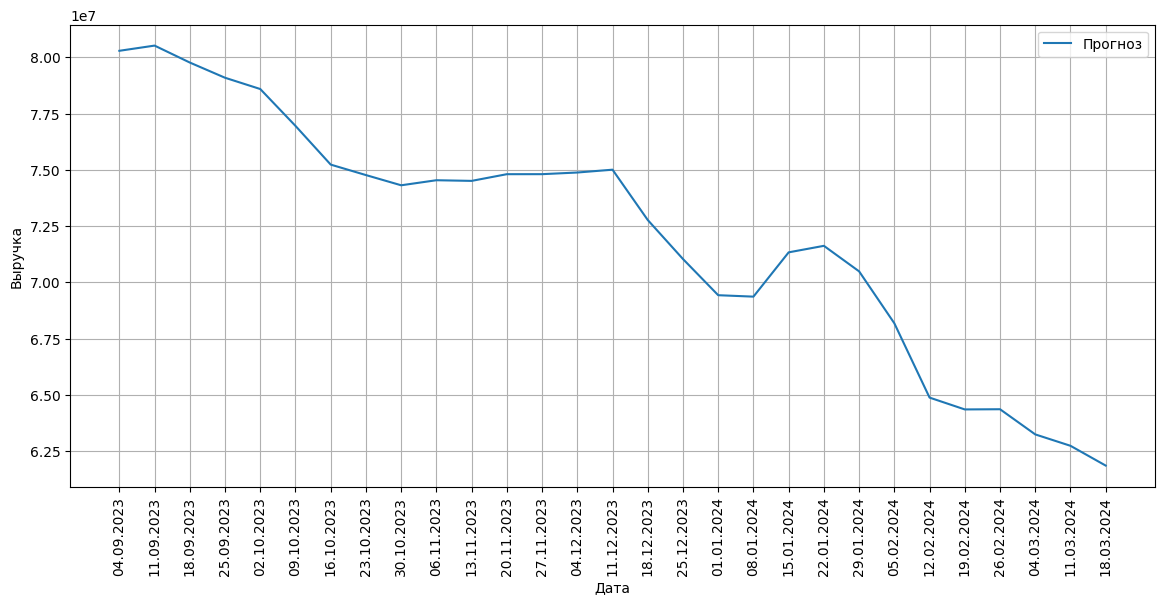

In [95]:
plt.figure(figsize = (14, 6), dpi = 100)
plt.plot(sample_submission.iloc[:,0], sample_submission.iloc[:,1], label = "Прогноз")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

In [96]:
sample_submission.to_csv('sample_submission_fin_6.csv', index = 0)

In [70]:
feature_importances

year            11.337338
std_generics     3.096683
std_value        2.988426
digital_23       2.596064
sales            2.222833
                  ...    
tv_22            0.014969
tv_26            0.013588
tv_25            0.010376
tv_21            0.003048
week             0.000000
Length: 130, dtype: float64

<Axes: >

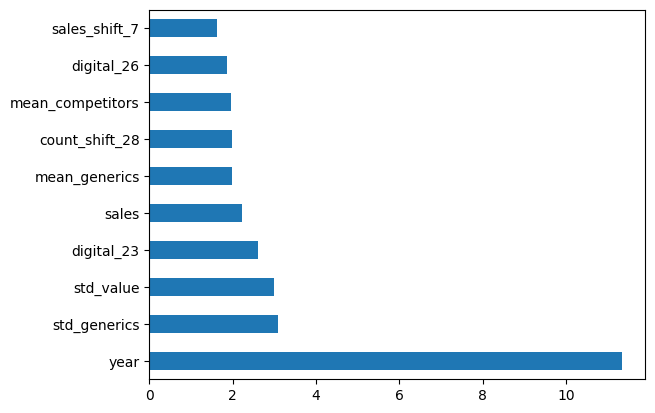

In [16]:
feature_importances.nlargest(10).plot(kind='barh')

<Axes: >

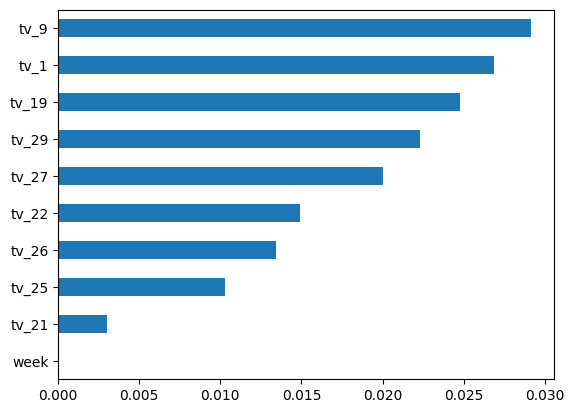

In [17]:
feature_importances.nsmallest(10).plot(kind='barh')